In [1]:
from __future__ import print_function
import numpy as np
import astropy.units as u
import astropy.constants as consts
import matplotlib.pyplot as plt
import OpenGoddard.optimize as og
import poliastro as pa
import math
import poliastro.bodies as paBody

In [2]:
class System():
    def __init__(self, attractor=paBody.Sun, lref = 1*u.AU, mref = 1*u.kg):
        
        #define constants
        self.attractor = attractor
        self.mu = consts.G*attractor.mass
        
        #define non-dimensionalization parameters
        self.lref = lref.si;
        self.mref = mref.si;
        self.vref = (np.sqrt(self.mu/self.lref)).si #v of orbit around the attractor at lref distance
        self.tref = (self.lref/self.vref).si #note, this is not one year
        self.aref = ((self.vref)**2/self.lref).si
        self.thref = 1*u.rad; #angular reference
        self.omref = (self.thref/self.tref).si; #angular velocity unit (om for omega)
        self.Fref  = self.mref*self.aref;
    
    def gravity(self,pos, dimensional=True):
        """
        Returns the gravitational acceleration at a given point, in polar coordinates. 
        Currently assumes there is only one attracting body.
        
        Arg:
            Pos: [r, theta] is the position from the main attractor
            Dimensional: If true, returns astropy quantities, else returns non-dimensionalized python scalars.
            
        Returns: (a_r, a_theta) which is the radial and tangential gravitational acceleration vector. 
        
        """
        
        if dimensional== True:
            a_r = -(self.mu/(pos[0]**2)).si
            a_t = 0*(a_r.unit) #ensure they are of the same units
        else:
            a_r = -(1/(pos[0]**2))
            a_t = 0 #ensure they are of the same units
        
        return (a_r, a_t)
        
    def __str__(self):
        return 'System with attractor: {}'.format(self.attractor)

In [98]:
class Mission():
    
    def __init__(self, system):
        """
        Initializes the Mission.
        
        Args:
            system (electricTortoise/System)
        
        """
        #Requires the system to be set up first. 
        #Calls on the system properties.
        
        self.sys = system
        
    def spacecraft_properties(self, c = 3000*u.m/u.s, F_max = 20*u.N):
        """ 
        Function defines the key parameters of the spacecraft
        
        Args: 
            c (Astropy/Quantity): Engine exhaust speed (for example in m/s)
        """
        
        self.c = c
        self.nd_c = float(self.c/self.sys.vref)
        
        self.F_max = F_max
        self.nd_F_max = float(F_max/self.sys.Fref)
        
    #set up the problem
    def define_problem_single_phase(self, num_nodes = 20, max_iterations = 5):
        
        """
        Defines the openGoddard problem statement, assuming the entire problem is to be solved in a single phase. 
        
        Args:
            num_nodes (int): Number of computation points in time axis.
            max_iterations (int):  Maximum number of iterations.
            
            Hint. 
            More nodes allow for higher degree approximations of the solution
            More iterations allow for finer tuning of the solution towards optimal. 
            
        Returns:
            None.
        """
        
        #Define time bounds
        time_init = [0.0, self.nd_T_max]
        
        n = [num_nodes]
        max_iterations = max_iterations
        
        #hard coded the number of states
        num_states = [5]
        num_controls = [2]
        
        #define problem
        self.problem = og.Problem(time_init, n, num_states, num_controls, max_iterations)
        
        #create time vector
        self.nd_time = self.problem.time_all_section
        self.time = self.nd_time*self.sys.tref
        return
    
    def get_states(self,states=[0,1,2,3,4]):
        """ Function returns tuple of state arrays of the states indicated"""
        return tuple([self.problem.states_all_section(i) for i in states])
    
    def get_controls(self, controls=[0,1]):
        """ Function returns tuple of control arrays of the states indicated"""
        return tuple([self.problem.controls_all_section(i) for i in controls])
    
    def dynamics(self, prob, obj, section):
        
        #states must be dimensionless here. Or at least in a consistent set of units.
        
        states = self.get_states()
        controls = self.get_controls()
        
        #determine rate of change of state
        changes = self.spacecraft_dynamics(states,controls,dimensionless=True,simple_gravity=True)
        
        #store into dynamics object
        dx = og.Dynamics(prob, section)
        for i in range(len(changes)):
            dx[i] = changes[i]
            
        return dx()
    
        
    def set_max_final_time(self, T_max = 3*u.year):
        """
        Sets the maximum final time of the mission (both dimensional and non-dimensional). 
        
        Args:
            T_max (Astropy/Quantity): Final time for mission.

        Returns:
            None.
        """
        
        self.T_max = T_max
        
        #set the non-dimensionalized float
        self.nd_T_max = float(T_max/self.sys.tref)
        
        return
    
    def set_full_initial_state(self, initial_state):
        """
        Sets the initial state of the problem fully.
        Using this function explicity sets the starting state.
        
        Args:
            initial_state (5x1 array of Astropy/Quantities): State vector. 
            
            State Vector = (Mass, Radial Position, Angular Position, Radial Velocity, Tangential Velocity)
            
        Retuns:
            None.
        """
        self.desired_initial_state = initial_state
            
        self.m0  = initial_state[0]
        self.r0  = initial_state[1]
        self.th0 = initial_state[2]
        self.vr0 = initial_state[3]
        self.vt0 = initial_state[4]
        
        #save non-dimensional versions
        self.nd_m0  = float(self.m0 /self.sys.mref);
        self.nd_r0  = float(self.r0 /self.sys.lref);
        self.nd_th0 = float(self.th0/self.sys.thref)
        self.nd_vr0 = float(self.vr0/self.sys.vref)
        self.nd_vt0 = float(self.vt0/self.sys.vref)
        
        return
    
    def set_full_final_state(self, final_state):
        """
        Sets the final state of the problem fully.
        Using this function explicity sets the ending state.
        
        Args:
            final_state (5x1 array of Astropy/Quantities): State vector. 
            
            State Vector = (Mass, Radial Position, Angular Position, Radial Velocity, Tangential Velocity)
            
        Retuns:
            None.
        """
        
        self.desired_final_state = final_state
        
        self.mf  = final_state[0]
        self.rf  = final_state[1]
        self.thf = final_state[2]
        self.vrf = final_state[3]
        self.vtf = final_state[4]
        
        #save non-dimensional versions
        self.nd_mf  = float(self.mf /self.sys.mref);
        self.nd_rf  = float(self.rf /self.sys.lref);
        self.nd_thf = float(self.thf/self.sys.thref)
        self.nd_vrf = float(self.vrf/self.sys.vref)
        self.nd_vtf = float(self.vtf/self.sys.vref)
        
        return
    
    def get_time_vector(self,dimensionless=False):
        """Getter for time vector. 
        
        Args:
            dimensionless (boolean): If True, returns float array of times. If False, returns time array as Astropy/Quantity
            
        Returns:
            Time vector.
        """
        #get updated time from the problem.
        self.nd_time = self.problem.time_update()
        self.time = self.nd_time*self.sys.tref;
        
        if dimensionless == True:
            return self.nd_time
        else:
            return self.time
    
    def spacecraft_dynamics(self, state, controls = None, dimensionless = True,simple_gravity = True):
        """
            Function returns the rate of change of the state of the spacecraft. 
        """
        m  = state[0]
        r  = state[1]
        th = state[2]
        vr = state[3]
        vt = state[4]
        
        if controls is not None:
            Tr = controls[0]
            Tt = controls[1]
        else:
            Tr = np.zeros_like(m)
            Tt = np.zeros_like(m)
            
        
        T_mag = np.sqrt(Tr**2+Tt**2)
        assert all(T_mag_i>0 for T_mag_i in T_mag), "negative Thrust magnitude!"
        
        if dimensionless == True:
            mdot = -T_mag/self.nd_c
            rdot = vr
            thdot = vt/r
            vrdot = vt**2 / r - 1 / r**2 + Tr/m
            vtdot = - vr * vt / r + Tt/m
        
        if dimensionless == False:
            mdot = -T_mag/self.c
            rdot = vr
            thdot = vt/r
            vrdot = vt**2 / r - self.sys.mu / r**2 + Tr/m
            vtdot = - vr * vt / r + Tt/m
            
        return (mdot,rdot,thdot,vrdot,vtdot)
    
    def set_guess_function(self,state,fguess, dimensionless=False):
        """
        This method applies fguess to each time point of the prescribed state.
        Assumes fguess is applied on dimensional quantities.
        Ensure the fguess takes in a time unit, and returns a quantity of the appropriate unit, 
        for example, if it is supposed to be a length, the units are AU or m etc. 
        If it is an angle, it must be in radians or degree or similar.
        
        """
        t = self.get_time_vector(dimensionless=dimensionless)
        
        if dimensionless == False:
            if state == 'm' or state == 0:
                state  = 0
                nond   = self.sys.mref;
            elif state == 'r' or state == 1:
                state  = 1
                nond   = self.sys.lref;
            elif state == 'th' or state == 2:
                state  = 2
                nond   = self.sys.thref;
            elif state == 'vr' or state == 3:
                state  = 3
                nond   = self.sys.vref;
            elif state == 'vt' or state == 4:
                state  = 4
                nond   = self.sys.vref;
            elif state == 'Tr':
                nond   = self.sys.Fref;
                
            elif state == 'Tt':
                nond   = self.sys.Fref;
                
            guess = np.array([float(fguess(ti)/nond) for ti in t]) #is the non-dimensionalized guess for this state.
        
        else:
            guess = np.array([fguess(ti) for ti in t]) #is the non-dimensionalized guess for this state.
        
        
        if state == 'm' or state == 0:
            state  = 0
            nond   = self.sys.mref;
        elif state == 'r' or state == 1:
            state  = 1
            nond   = self.sys.lref;
        elif state == 'th' or state == 2:
            state  = 2
            nond   = self.sys.thref;
        elif state == 'vr' or state == 3:
            state  = 3
            nond   = self.sys.vref;
        elif state == 'vt' or state == 4:
            state  = 4
            nond   = self.sys.vref;
        elif state == 'Tr':
            nond   = self.sys.Fref;
            self.problem.set_controls_all_section(0,guess)
            return
        elif state == 'Tt':
            nond   = self.sys.Fref;
            self.problem.set_controls_all_section(1,guess)
            return
        
        
        self.problem.set_states_all_section(state,guess)
        
        return
    
    def set_guess_value(self,state,guess,dimensionless = False):
        """
        Function to set the initial guess of the variable.
        Args:
            state (string or int): reference of state (amongst 'm','r','th','vr','vt' or the index in that order)
            guess (numpy array): of same size as time vector, indicating the guess at each of the times. 
        """
        
        assert len(guess) == len(self.get_time_vector()) , "Length of guess doesnt match length of time vector"
        
        #non dimensionalize
        if dimensionless == False:
            if state == 'm' or state == 0:
                nond = self.sys.mref;
            elif state == 'r' or state == 1:
                nond = self.sys.lref;
            elif state == 'th' or state == 2:
                nond = self.sys.thref;
            elif state == 'vr' or state == 'vt' or state == 3 or state == 4:
                nond = self.sys.vref;
            elif state == 'Tr':
                nond = self.sys.Fref;
            elif state == 'Tt':
                nond = self.sys.Fref;
            
            guess = np.array([float(guessi/nond) for guessi in guess])
        
        #convert to index
        if state == 'm':
            state = 0
            self.problem.set_states_all_section(state,guess)
            return
        elif state == 'r':
            state = 1
            self.problem.set_states_all_section(state,guess)
            return
        elif state == 'th':
            state = 2
            self.problem.set_states_all_section(state,guess)
            return
        elif state == 'vr':
            state = 3
            self.problem.set_states_all_section(state,guess)
            return
        elif state == 'vt':
            state = 4
            self.problem.set_states_all_section(state,guess)
            return
        elif state == 'Tr':
            self.problem.set_controls_all_section(0,guess)
            return
        elif state == 'Tt':
            self.problem.set_controls_all_section(1,guess)
            return
        
        return
    
    def set_guess_value(self,state,guess,dimensionless = False):
        """
        Function to set the initial guess of the variable.
        Args:
            state (string or int): reference of state (amongst 'm','r','th','vr','vt' or the index in that order)
            guess (numpy array): of same size as time vector, indicating the guess at each of the times. 
        """
        
        assert len(guess) == len(self.get_time_vector()) , "Length of guess doesnt match length of time vector"
        
        #non dimensionalize
        if dimensionless == False:
            if state == 'm' or state == 0:
                nond = self.sys.mref;
            elif state == 'r' or state == 1:
                nond = self.sys.lref;
            elif state == 'th' or state == 2:
                nond = self.sys.thref;
            elif state == 'vr' or state == 'vt' or state == 3 or state == 4:
                nond = self.sys.vref;
            
            guess = np.array([float(guessi/nond) for guessi in guess])
        
        #convert to index
        if state == 'm':
            state = 0
        elif state == 'r':
            state = 1
        elif state == 'th':
            state = 2
        elif state == 'vr':
            state = 3
        elif state == 'vt':
            state = 4
        
        self.problem.set_states_all_section(state,guess)
        
        return
    
    def set_guess_all_states_linear(self):
        """
        Function sets the intial guess to be linear between the starting state and the final state
        """
        
        tf = float((self.get_time_vector())[-1]/self.sys.tref);
        
        # mass
        m_func = lambda t: self.nd_m0+(self.nd_mf-self.nd_m0)*(t/tf)
        self.set_guess_function('m',m_func,dimensionless=True)
        
        # r
        r_func = lambda t: self.nd_r0+(self.nd_rf-self.nd_r0)*(t/tf)
        self.set_guess_function('r',r_func,dimensionless=True)
        
        # th
        th_func = lambda t: self.nd_th0+(self.nd_thf-self.nd_th0)*(t/tf)
        self.set_guess_function('th',th_func,dimensionless=True)
        
        # vr
        vr_func = lambda t: self.nd_vr0+(self.nd_vrf-self.nd_vr0)*(t/tf)
        self.set_guess_function('vr',vr_func,dimensionless=True)
        
        # vt
        vt_func = lambda t: self.nd_vt0+(self.nd_vtf-self.nd_vt0)*(t/tf)
        self.set_guess_function('vt',vt_func,dimensionless=True)
        
        Tr_func = lambda t: self.nd_F_max
        self.set_guess_function('Tr',Tr_func,dimensionless=True)
        
        Tt_func = lambda t: self.nd_F_max
        self.set_guess_function('Tt',Tt_func,dimensionless=True)
        
    def plot_all_states(self,dimensionless=True, save_dir=None):
        """
        Function plots each state.
        Args:
            dimensionless (boolean): Determines whether to plot in non-dimensional quantities or not.
            
        """
        if dimensionless == False:
            raise ValueError('dimensioned quantities not implemented yet')
            
        elif dimensionless == True:
            t = self.get_time_vector(dimensionless=True)
            states = self.get_states()
            
            for i in range(len(states)):
                plt.figure()
                plt.plot(t,states[i],'.-')
                plt.xlabel('t [-]')
                plt.ylabel(f'State {i}')
                plt.title(f'State {i}')
                plt.grid(True)
    
        
    

In [99]:
sys = System(lref=1*u.AU, mref=2000*u.kg)
mission=Mission(sys)
mission.set_max_final_time(2*u.year)
mission.spacecraft_properties(c = 3000*u.m/u.s,F_max = 1*u.N)
mission.set_full_initial_state([2000*u.kg, 1*u.AU, 0*u.rad, 0*u.m/u.s, mission.sys.vref])
mission.set_full_final_state([1000*u.kg, 2*u.AU, 4*np.pi*u.rad, 0*u.m/u.s, mission.sys.vref*np.sqrt(1/2)])

In [100]:
mission.define_problem_single_phase(num_nodes = 100, max_iterations = 5)

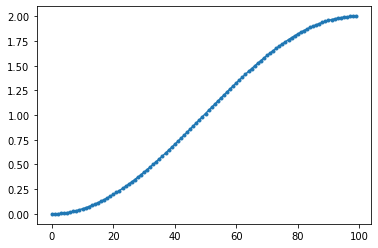

In [101]:
plt.plot(mission.get_time_vector(dimensionless=False).to(u.year),'.-')

In [102]:
mission.get_time_vector()

<Quantity [0.00000000e+00, 2.33975000e+04, 7.84127770e+04, 1.64815651e+05,
           2.82513301e+05, 4.31387222e+05, 6.11288677e+05, 8.22038210e+05,
           1.06342569e+06, 1.33521046e+06, 1.63712159e+06, 1.96885813e+06,
           2.33008938e+06, 2.72045525e+06, 3.13956662e+06, 3.58700571e+06,
           4.06232650e+06, 4.56505519e+06, 5.09469062e+06, 5.65070487e+06,
           6.23254367e+06, 6.83962704e+06, 7.47134982e+06, 8.12708230e+06,
           8.80617084e+06, 9.50793849e+06, 1.02316857e+07, 1.09766911e+07,
           1.17422120e+07, 1.25274852e+07, 1.33317282e+07, 1.41541390e+07,
           1.49938980e+07, 1.58501681e+07, 1.67220957e+07, 1.76088116e+07,
           1.85094320e+07, 1.94230590e+07, 2.03487821e+07, 2.12856784e+07,
           2.22328139e+07, 2.31892445e+07, 2.41540170e+07, 2.51261695e+07,
           2.61047329e+07, 2.70887320e+07, 2.80771856e+07, 2.90691087e+07,
           3.00635123e+07, 3.10594052e+07, 3.20557948e+07, 3.30516877e+07,
           3.40460913e+07

In [103]:
mission.set_guess_all_states_linear()

In [104]:
mission.get_states([0])

(array([1.        , 0.99981464, 0.99937881, 0.99869433, 0.99776192,
        0.99658254, 0.99515736, 0.9934878 , 0.99157552, 0.98942243,
        0.98703069, 0.98440266, 0.98154098, 0.97844849, 0.97512828,
        0.97158366, 0.96781816, 0.96383553, 0.95963975, 0.95523499,
        0.95062565, 0.94581632, 0.9408118 , 0.93561708, 0.93023732,
        0.9246779 , 0.91894436, 0.91304241, 0.90697794, 0.90075699,
        0.89438576, 0.8878706 , 0.88121801, 0.87443462, 0.86752719,
        0.86050261, 0.85336787, 0.8461301 , 0.8387965 , 0.83137439,
        0.82387116, 0.8162943 , 0.80865135, 0.80094993, 0.79319773,
        0.78540247, 0.77757192, 0.76971388, 0.7618362 , 0.75394671,
        0.74605329, 0.7381638 , 0.73028612, 0.72242808, 0.71459753,
        0.70680227, 0.69905007, 0.69134865, 0.6837057 , 0.67612884,
        0.66862561, 0.6612035 , 0.6538699 , 0.64663213, 0.63949739,
        0.63247281, 0.62556538, 0.61878199, 0.6121294 , 0.60561424,
        0.59924301, 0.59302206, 0.58695759, 0.58

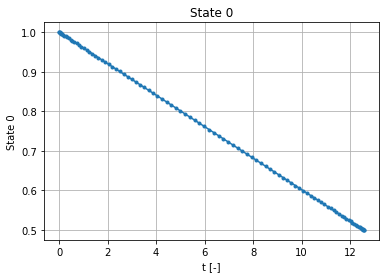

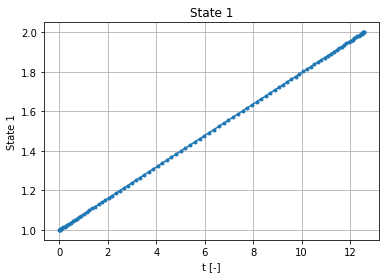

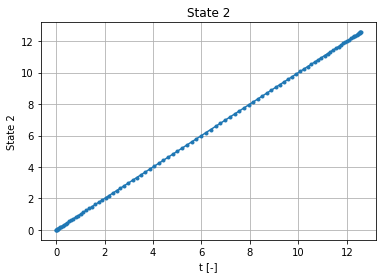

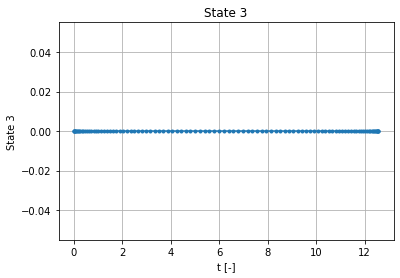

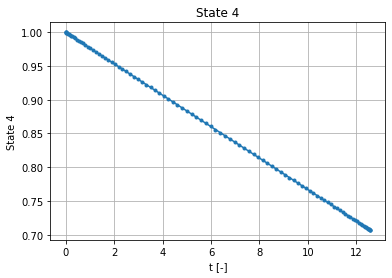

In [105]:
mission.plot_all_states()

In [106]:
def equality(prob, obj):
    m   = prob.states_all_section(0)
    r  = prob.states_all_section(1)
    th  = prob.states_all_section(2)
    vr   = prob.states_all_section(3)
    vt  = prob.states_all_section(4)
    
    Tr  = prob.controls_all_section(0)
    Tt  = prob.controls_all_section(1)

    tf  = prob.time_final(-1)

    result = og.Condition()

    # event condition
    result.equal(m[0], obj.nd_m0)
    result.equal(r[0], obj.nd_r0)
    result.equal(th[0],obj.nd_th0)
    result.equal(vr[0],0)
    result.equal(vt[0],1) #how we defined vref

    result.equal(r[-1], 2)
    result.equal(vr[-1], 0)
    result.equal(vt[-1], 1/np.sqrt(2)) #has to hit this tangential velocity
    
    #compute venus flyby requirement
    #vrf=vr[-1]
    #vtf=vt[-1]
    #v_c3minus = vrf**2 + (vtf-obj.v_v)**2
    #result.equal(v_c3minus, obj.v_vinf**2)

    #result.equal(tf, 1*year/obj.tref)
    #result.equal(th[-1], (369.55*tf*obj.tref/year - 59.433)*pi/180)
    
    #result.equal(th[-1],th_venus)

    return result()

In [107]:
def inequality(prob, obj):
    m   = prob.states_all_section(0)
    r   = prob.states_all_section(1)
    th  = prob.states_all_section(2)
    vr  = prob.states_all_section(3)
    vt  = prob.states_all_section(4)
    
    
    Tr = prob.controls_all_section(0)
    Tt = prob.controls_all_section(1)

    tf  = prob.time_final(-1)
    
    FmagSq = Tr**2 + Tt**2
    
    result = og.Condition()

    # lower bounds
    #result.lower_bound(r[-1], 2)
    result.lower_bound(Tr, -obj.nd_F_max)
    result.lower_bound(Tt, -obj.nd_F_max)
    result.lower_bound(th, 0)
    result.lower_bound(m, 0)
    
    result.lower_bound(tf, 0.0)

    # upper bounds
    result.upper_bound(r, 3)
    result.upper_bound(FmagSq, obj.nd_F_max**2)
    result.upper_bound(Tr,   +obj.nd_F_max)
    result.upper_bound(Tt,   +obj.nd_F_max)
    
    result.upper_bound(tf, obj.nd_T_max)
    result.upper_bound(m, obj.nd_m0)
    

    return result()


In [108]:
def cost(prob,obj):
    m = prob.states_all_section(0)
    return -m[-1]

def running_cost(prob, obj):
    return 0

In [109]:
def display_func():
    mf = (mission.problem.states_all_section(0))[-1]
    print("mf: {0:.5f} kg".format(mf*mission.sys.mref))
    return

In [110]:
mission.problem.dynamics = [mission.dynamics]
mission.problem.knot_states_smooth = []
mission.problem.cost = cost
mission.problem.equality = equality
mission.problem.inequality = inequality

In [111]:
mission.problem.solve(mission, display_func, ftol=1e-6)

---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.1417707360728918
            Iterations: 26
            Function evaluations: 18309
            Gradient evaluations: 26
Iteration limit exceeded
mf: 283.54147 kg kg

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.14573678032260345
            Iterations: 26
            Function evaluations: 18339
            Gradient evaluations: 26
Iteration limit exceeded
mf: 291.47356 kg kg

---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.14914928790712473
            Iterations: 26
            Function evaluations: 18340
            Gradient evaluations: 26
Iteration limit exceeded
mf: 298.29858 kg kg

---- iteration : 4 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -0.15357277211309775
            Iterations: 26
            Function evaluations

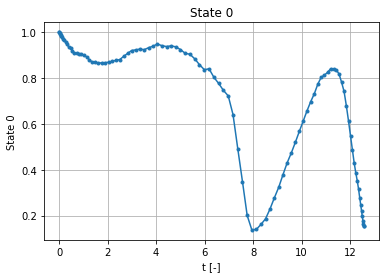

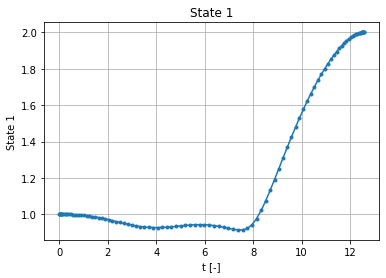

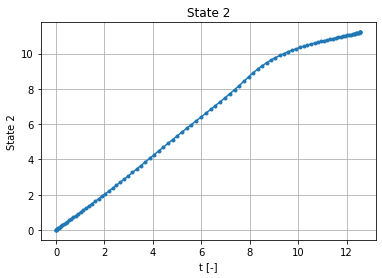

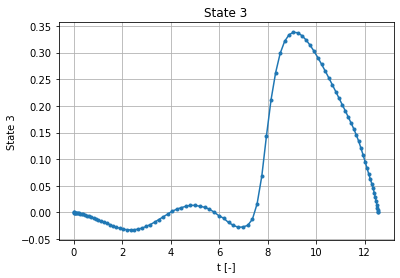

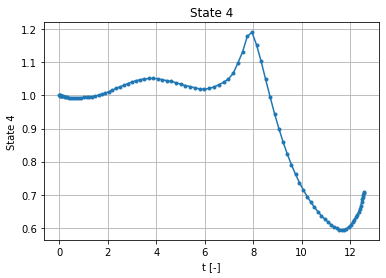

In [112]:
mission.plot_all_states()

In [113]:
mission.get_states()

(array([1.        , 0.99892149, 0.99640816, 0.99212261, 0.98859452,
        0.98346063, 0.97901537, 0.97141797, 0.96501466, 0.9567075 ,
        0.9469191 , 0.93481907, 0.93009439, 0.91957838, 0.90863786,
        0.90764077, 0.90558678, 0.90537921, 0.89907565, 0.89291678,
        0.88028483, 0.86945019, 0.87183658, 0.86437582, 0.86712717,
        0.86733965, 0.86927512, 0.87309688, 0.87747119, 0.88072573,
        0.89436397, 0.90755183, 0.92023811, 0.92313676, 0.92650031,
        0.92395953, 0.93261228, 0.93891228, 0.9487109 , 0.94131151,
        0.93767929, 0.94058861, 0.93634875, 0.92444837, 0.90809158,
        0.90400774, 0.88427665, 0.85857443, 0.83692194, 0.84026212,
        0.80366822, 0.77657002, 0.74614949, 0.72227384, 0.64072254,
        0.49206517, 0.34803915, 0.20089415, 0.13776755, 0.14031024,
        0.1621481 , 0.18609719, 0.22887998, 0.27811397, 0.32398292,
        0.37922102, 0.43117766, 0.47400715, 0.52035668, 0.56802211,
        0.61311886, 0.65738691, 0.6975003 , 0.73

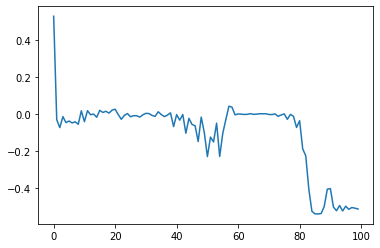

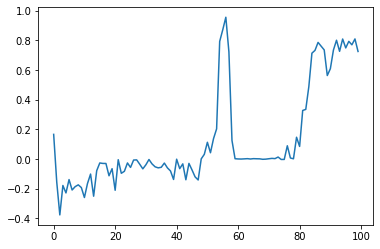

In [114]:
for i in range(2):
    plt.figure()
    plt.plot(mission.sys.Fref*mission.problem.controls_all_section(i))
    

In [115]:
mission.sys.Fref*np.sqrt(mission.problem.controls_all_section(0)**2 + mission.problem.controls_all_section(1)**2)

<Quantity [5.52044099e-01, 1.58264956e-01, 3.83547627e-01, 1.78804274e-01,
           2.33080460e-01, 1.43560573e-01, 2.14170499e-01, 1.90667900e-01,
           1.82598172e-01, 1.92957064e-01, 2.62610745e-01, 1.66094597e-01,
           1.01444634e-01, 2.50469218e-01, 8.05543430e-02, 3.33067646e-02,
           3.09638128e-02, 3.34013294e-02, 1.12972710e-01, 6.83125956e-02,
           2.12142457e-01, 5.42872992e-03, 1.00227413e-01, 8.30545324e-02,
           2.67046978e-02, 5.85976499e-02, 1.13804729e-02, 1.08070310e-02,
           3.91205954e-02, 6.63973726e-02, 3.88952729e-02, 3.97735814e-03,
           3.39348235e-02, 5.41007175e-02, 6.07533488e-02, 5.57466036e-02,
           3.06852402e-02, 6.00197797e-02, 8.07500143e-02, 1.53457813e-01,
           3.50465613e-03, 7.28654591e-02, 3.27746126e-02, 1.73780311e-01,
           3.75515191e-02, 9.24630480e-02, 1.35915135e-01, 2.04544411e-01,
           1.66825437e-02, 1.05059867e-01, 2.55637411e-01, 1.31271465e-01,
           2.03671849e-01

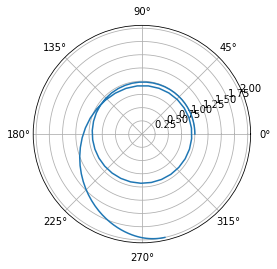

In [116]:
plt.polar(mission.get_states([2])[0],mission.get_states([1])[0])

In [117]:
mission.get_states([2])[0]

array([0.00000000e+00, 4.65844675e-03, 1.56103639e-02, 3.28040179e-02,
       5.62168696e-02, 8.58179459e-02, 1.21573227e-01, 1.63434010e-01,
       2.11349220e-01, 2.65264670e-01, 3.25109475e-01, 3.90798646e-01,
       4.62289791e-01, 5.39532522e-01, 6.22406628e-01, 7.10930176e-01,
       8.05099929e-01, 9.04882990e-01, 1.01023071e+00, 1.12105992e+00,
       1.23734410e+00, 1.35896203e+00, 1.48609460e+00, 1.61870796e+00,
       1.75684562e+00, 1.90063897e+00, 2.05011998e+00, 2.20542245e+00,
       2.36659513e+00, 2.53358440e+00, 2.70629024e+00, 2.88467890e+00,
       3.06866289e+00, 3.25794083e+00, 3.45212739e+00, 3.65077351e+00,
       3.85339017e+00, 4.05947690e+00, 4.26835978e+00, 4.47929312e+00,
       4.69162154e+00, 4.90516291e+00, 5.11937398e+00, 5.33386304e+00,
       5.54816063e+00, 5.76242234e+00, 5.97651225e+00, 6.19033007e+00,
       6.40412777e+00, 6.61871647e+00, 6.83459562e+00, 7.05247374e+00,
       7.27253378e+00, 7.49521948e+00, 7.72101479e+00, 7.95227369e+00,
      